In [1]:
import numpy as np

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from time import time

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# Load CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,
                                             download=True,
                                             transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='data/',
                                            train=False,
                                            download=True,
                                            transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
from ResNet import Bottleneck, ResNet, ResNet50
import torch.nn as nn
import torch.nn.functional as F

num_classes = 10
import torchvision.models as models

num_batches = 3
batch_size = 120
image_w = 128
image_h = 128



class ModelParallelResNet50(ResNet):
    def __init__(self, *args, **kwargs):
        super(ModelParallelResNet50, self).__init__(
            Bottleneck, [3, 4, 6, 3], num_classes=num_classes, *args, **kwargs)

        self.seq1 = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.maxpool,

            self.layer1,
            self.layer2
        )

        self.seq2 = nn.Sequential(
            self.layer3,
            self.layer4,
            self.avgpool,
        )

    def forward(self, x):
        x = self.seq2(self.seq1(x).to('cuda:1'))
        return self.fc(x.view(x.size(0), -1))

In [4]:
# model = ModelParallelResNet50()
model = ResNet50(10)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, m

In [5]:
# import torch.nn as nn
# import torch.nn.functional as F


# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# model = Net()
# model.to(device)

In [6]:
# Define dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# # Define model
# model = MyModel()

# # Move model to device
# model = model.to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

# Enable optimizer state sharding
# optimizer = optim.ShardedSGD(model.parameters(), lr=0.001, momentum=0.9, num_shards=2)


In [7]:
# Set number of GPUs
num_gpus = torch.cuda.device_count()

# Use data parallelism
if num_gpus > 1:
    model = torch.nn.DataParallel(model) #With 1 GPU, this won't run

In [8]:
from trainer import Trainer
from visualizer import *

In [9]:
# trainer
num_epochs = 100
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_dataloader=train_dataloader,
                  validation_dataloader=test_dataloader,
                  lr_scheduler=None,
                  epochs=num_epochs,
                  epoch=0,
                  notebook=True)

# start training
training_losses, validation_losses, lr_rates, training_times = trainer.run_trainer()

Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

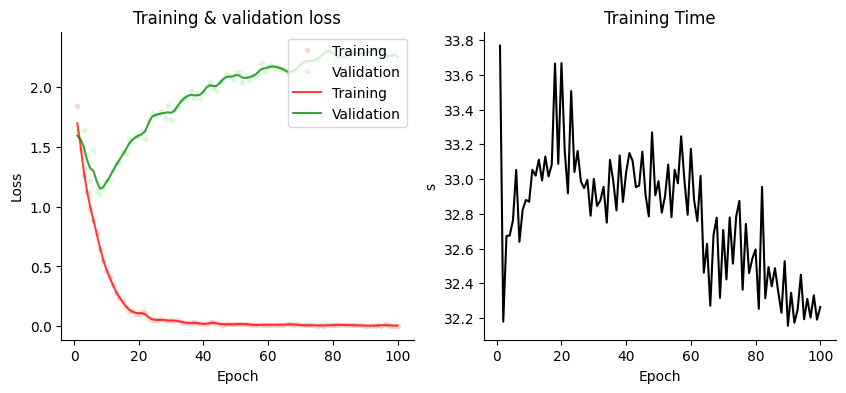

In [10]:
fig = plot_training(training_losses,
    validation_losses,
    training_times,
    gaussian=True,
    sigma=1,
    figsize=(10, 4),
)

In [11]:
total_training_time = np.sum(training_times)
print("The total Training Time for the model is "+ str(total_training_time/60) + "mins")

The total Training Time for the model is 54.65760313272476mins


In [13]:
mean_training_time = np.mean(training_times)
print("The Avg Training Time for the model is "+ str(mean_training_time) + "s")

The Avg Training Time for the model is 32.794561879634855s
